<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

RANDOM_STATE = 42
TEST_SIZE = 0.1

In [2]:
# загрузка данных 

try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    


In [3]:
# Проверим индекс на монотонность

display(data.index.is_monotonic)
display(data.info())
display(data.head())

True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# ресемплирование по 1 часу

data = data.resample('1H').sum()

- данные загружены
- осуществлена настройка индекса
- данные отсартированы по индексу 
- пропусков нет
- выполнено ресемплирование по 1 часу

## Анализ

In [5]:
# Декомпозиция временного ряда на тренд, сезонность и шум с правильной переменной

decomposition = seasonal_decompose(data)



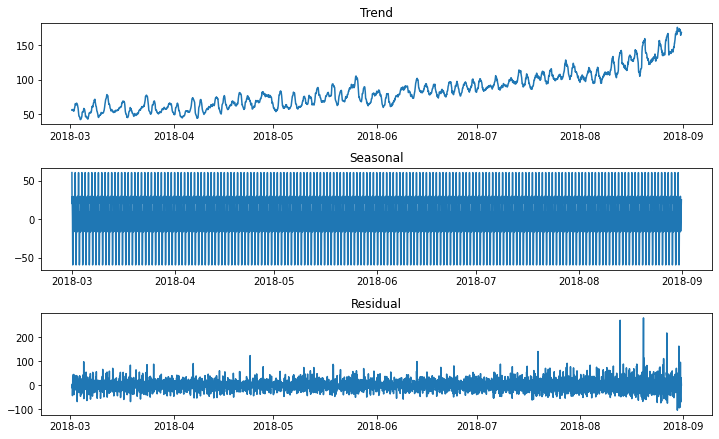

In [6]:
# Построим графики
plt.figure(figsize=(10, 8))

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

- наблюдается тренд (идет рост заказов)
- также присутствует сезонность

## Обучение

In [7]:
# Функция генерации признаков

def get_features(df):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(5).mean()
    df.dropna(inplace=True)
    return df

data = get_features(data)


In [8]:
# Разделение данных

X = data.drop(columns=['num_orders'])
y = data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [9]:
# Обучение моделей

models = []

In [10]:
# Линейная регрессия

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
models.append(('LinearRegression', rmse))

In [11]:
# DecisionTreeRegressor

params = {'max_depth': range(1, 11, 2)}
ts_cv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(DecisionTreeRegressor(random_state=17), params, cv=ts_cv)
gsearch.fit(X_train, y_train)
predictions = gsearch.best_estimator_.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
models.append(('DecisionTreeRegressor', rmse))

In [12]:
# RandomForestRegressor

params = {'n_estimators': range(50, 100, 10), 'max_depth': range(1, 11, 2)}
gsearch = GridSearchCV(RandomForestRegressor(random_state=17), params, cv=ts_cv)
gsearch.fit(X_train, y_train)
predictions = gsearch.best_estimator_.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
models.append(('RandomForestRegressor', rmse))


In [13]:
# LightGBM

model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
models.append(('LightGBM', rmse))

## Тестирование

In [14]:
# Вывод результатов

result = pd.DataFrame(models, columns=['Model', 'RMSE'])
print(result.sort_values(by='RMSE'))

                   Model       RMSE
3               LightGBM  44.431423
2  RandomForestRegressor  48.831177
0       LinearRegression  52.692761
1  DecisionTreeRegressor  57.534135



**Выводы:**
1. Наилучший результат показала модель `LightGBM с RMSE = 44.43`, что соответствует поставленному требованию (RMSE <= 48).
2. `RandomForestRegressor` также показал достойный результат `RMSE = 48.83`, но чуть хуже `LightGBM`.
3. `Линейная регрессия и DecisionTreeRegressor` продемонстрировали худшие результаты, что говорит о том, что они не справляются с прогнозированием временного ряда.
4. Для дальнейшего улучшения модели можно попробовать добавить больше лагов, использовать дополнительные признаки или использовать ансамблирование моделей.